In [1]:
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')


from math import sqrt
import pandas as pd

import torch
import torch.nn.functional as F
from rdkit import Chem

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn.models import AttentiveFP

In [2]:
from clsar.dataset import LSSInhibitor # dataset
from clsar.feature import Gen115AtomFeatures, GenAttentiveFeatures # feature
from clsar.model import ACNet_GCN, ACNet_GIN, ACNet_GAT, ACNet_PNA # model

In [3]:
dataset_name = 'mth1'
Dataset =  LSSInhibitor # MoleculeNet
epochs = 500

pre_transform = Gen115AtomFeatures()
in_channels = 115
path = '../../tmp/data1'

dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle()

batch_size = 16

# train, valid, test splitting
N = len(dataset) // 5
val_dataset = dataset[:N]
test_dataset = dataset[N:2 * N]
train_dataset = dataset[2 * N:]


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
## 4 kind of models
pub_args = {'in_channels':115, 'hidden_channels':64, 'out_channels':1,
            'edge_dim':10, 'num_layers':2, 'dropout_p':0.2, 'batch_norms':None}

model_1 = ACNet_GCN(**pub_args).to(device)

model_2 = ACNet_GIN(**pub_args, eps = 0.0, train_eps = False).to(device)

model_3 = ACNet_GAT(**pub_args, dropout = 0.1, heads=3).to(device)

model_4 = ACNet_PNA(**pub_args, aggregators = ['mean', 'max', 'sum'],
                    scalers = ['identity', 'amplification'], 
                    deg = torch.tensor([1, 2, 3]),
                   ).to(device)

In [5]:
res = {}
for model, name in zip([model_1, model_2, model_3, model_4],['ACNet_GCN', 'ACNet_GIN', 'ACNet_GAT', 'ACNet_PNA']):

    print(name, '#'*50)
    
    def train():
        total_loss = total_examples = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
            loss = F.mse_loss(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
            total_examples += data.num_graphs
        return sqrt(total_loss / total_examples)

    @torch.no_grad()
    def test(loader):
        mse = []
        for data in loader:
            data = data.to(device)
            out = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
            mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
        return float(torch.cat(mse, dim=0).mean().sqrt())

    optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                                 weight_decay=10**-5)
    history = []
    for epoch in range(1, epochs):
        train_rmse = train()
        val_rmse = test(val_loader)
        test_rmse = test(test_loader)
        print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
              f'Test: {test_rmse:.4f}')

        history.append({'Epoch':epoch, 'train_rmse':train_rmse, 'val_rmse':val_rmse, 'test_rmse':test_rmse})
        
    print('\n')
    res.update({name:history})

ACNet_GCN ##################################################
Epoch: 001, Loss: 7.0131 Val: 5.7187 Test: 5.2517
Epoch: 002, Loss: 5.5894 Val: 3.9782 Test: 4.5865
Epoch: 003, Loss: 4.4839 Val: 3.0319 Test: 3.9592
Epoch: 004, Loss: 3.8899 Val: 2.8278 Test: 3.2663
Epoch: 005, Loss: 3.3396 Val: 3.3060 Test: 4.1024
Epoch: 006, Loss: 2.9651 Val: 3.1490 Test: 4.7408
Epoch: 007, Loss: 3.4329 Val: 4.1397 Test: 4.4664
Epoch: 008, Loss: 3.6308 Val: 3.8504 Test: 4.1894
Epoch: 009, Loss: 3.6288 Val: 3.3016 Test: 4.0239
Epoch: 010, Loss: 3.3059 Val: 2.7762 Test: 3.6260
Epoch: 011, Loss: 3.1325 Val: 3.2927 Test: 3.7556
Epoch: 012, Loss: 3.1726 Val: 2.2354 Test: 2.6223
Epoch: 013, Loss: 2.6284 Val: 2.0214 Test: 2.4141
Epoch: 014, Loss: 2.6358 Val: 2.5166 Test: 2.6313
Epoch: 015, Loss: 2.4936 Val: 1.4047 Test: 1.8853
Epoch: 016, Loss: 2.5443 Val: 1.2141 Test: 1.9319
Epoch: 017, Loss: 2.5967 Val: 2.0061 Test: 2.2685
Epoch: 018, Loss: 2.3696 Val: 1.4375 Test: 1.9122
Epoch: 019, Loss: 2.3900 Val: 1.9504 Te

In [6]:
import pandas as pd
df = pd.DataFrame(res)

test_rmse = pd.concat(df.apply(lambda x:x.apply(pd.Series).test_rmse.to_frame(name = x.name), axis=1).to_list(), axis=1).T
val_rmse = pd.concat(df.apply(lambda x:x.apply(pd.Series).val_rmse.to_frame(name = x.name), axis=1).to_list(), axis=1).T

<AxesSubplot:>

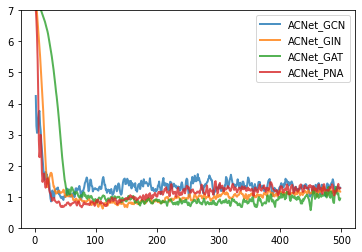

In [11]:
val_rmse.rolling(3).mean().plot(ylim = (0,7), lw=2, alpha=0.8)

<AxesSubplot:>

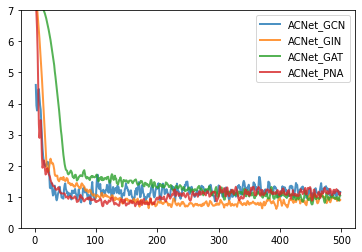

In [12]:
test_rmse.rolling(3).mean().plot(ylim = (0,7), lw=2, alpha=0.8)